In [1]:
# !pip3 install contextily
# !pip3 install earthpy

In [2]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import json
import os
import seaborn as sns #sn? sns?

import numpy.ma as ma
import rasterio as rio
from rasterio.plot import plotting_extent

import contextily as cx

# Rasterstats contains the zonalstatistics function 
# that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

import re
import time
import glob

# Contributing Datasets: Summary and Exploratory Data Analysis 

In this notebook we show to show maps and basic trends and patterns in each dataset we used, followed by analysis on the final dataset containing our target variable and features. 

Each dataset: 
- AVIRIS-NG Methane Concentration
- AirNow measurements
- TROPOMI 
- USGS National Land Cover Data (NLCD)
- VISTA points
    - Potential emitter location
    - Distance to closest neighboring emitter 
    - Emitter type 
- Cow density
- Length of natural gas pipeline 

## EDA: Aviris Flights Methane Data

#### Import the AVIRIS CH$_4$ estimates

In [1]:
aviris_ch4_path = os.sep.join(['Data', 'AVIRIS_CH4.geojson'])
aviris_ch4_all = gpd.read_file(aviris_ch4_path)

NameError: name 'os' is not defined

In [ ]:
print(aviris_ch4_all.shape)
aviris_ch4_all.head(5)

### Exploratory data analysis
`aviris_ch4_all` is a dataframe of dimension [234576, 15]. This contains the information we need for our response variable. Let's take a look around.

The key observation in the dataset is `CH4_Mass_kg`. This will be our response variable, and as noted above, it represents a direct measure of the mass in kg of CH$_4$ above each facility that was emitting a CH$_4$ plume during the time of overflight. There are several thousand `NaN` values, so we'll remove those so that we're only working with facilities for which an emission estimate exists.

In [1]:
aviris_ch4_valid = aviris_ch4_all[aviris_ch4_all['CH4_Mass_kg'].notna()]

NameError: name 'aviris_ch4_all' is not defined

There are 16 unique emitter types represented in the dataset, below.

In [ ]:
print(aviris_ch4_valid['Vista_SType'].unique())

As the histogram below shows, the mass observations are skewed positively. The lowest CH$_4$ mass values occur factor-4 more frequently than the highest.

In [ ]:
plt.hist(aviris_ch4_valid['CH4_Mass_kg'], bins = 15, color = 'tomato')
plt.yscale('log')
plt.title('Frequency distribution of observed CH4 mass (kg) above emitting facility locations', fontsize = 20)
plt.xlabel('Observed CH4 mass (kg)')
plt.ylabel('Log(10) of frequency');

We can see how balanced the dataset is by looking at the number of observations per emitter type. It's fairly unbalanced: on a log scale, oil and gas wells represent approximately 4.7x10$^4$ facilities, while the rest are on an order of magnitude of 10$^2$ and 10$^3$. However, when we consider mean emissions per facility, each oil and gas facility appears to emit around the same order of magnitude as other types.

In [ ]:
aviris_ch4_typecount = aviris_ch4_all.groupby('Vista_SType')['CH4_Mass_kg'].count()
aviris_ch4_kgsum = aviris_ch4_all.groupby('Vista_SType')['CH4_Mass_kg'].mean()

In [ ]:
ind = range(len(aviris_ch4_typecount))
width = np.min(np.diff(ind))/3.
names = list(aviris_ch4_typecount.index)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(ind-width/2., height = aviris_ch4_typecount, width = width, color = 'dimgrey', label = 'Count of facilities')
ax.bar(ind+width/2., height = aviris_ch4_kgsum, width = width, color = 'royalblue', label = 'Mean CH$_4$ (kg) per facility')
ax.axes.set_xticklabels(names)
plt.yscale('log')
plt.xticks(ind, rotation=90)
plt.title('Number of observations and mean CH4 (kg) per facility type', fontsize = 20)
plt.xlabel('Facility type')
plt.ylabel('Log(10) of number of facilities and mean CH$_4$ (kg) per facility type')
plt.legend();

Breaking the distribution of emission values down by emitter type, the medians are roughly on par. Digesters have the highest median emissions, and natural gas storage fields the lowest. Emissions from feed lots and dairies appear to vary widely, and feedlots, dairies, and wastewater treament plants to be rather positively skewed.

In [ ]:
#plt.figure(figsize=(25,10))
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.boxplot(x = aviris_ch4_valid['Vista_SType'], y = aviris_ch4_valid['CH4_Mass_kg'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Distribution of observed CH4 mass (kg) above 16 emitting facility types', fontsize=20)
plt.xlabel('Facility type')
plt.ylabel('CH4 Mass (kg) observed above facility location');

The primary concern that exploration of the AVIRIS CH$_4$ data raises is that of balance. With such a massive preponderance of observations from oil and gas wells, it's possible that the one-hot-coded `Oil and Gas Well` facility type predictor could have an exaggerated coefficient weight, and/or that the predictions for other categories of emitter are distorted by the big weight of a single emitter type.

## EDA: TROPOMI

A Google Earth Engine script was used to limit our study area and take monthly averages of the parameter in question. Here's an example of that code:

```
var table = ee.FeatureCollection("users/hmurayama/CA_State_TIGER2016");

// Add layer objects
Map.centerObject(table);
Map.setZoom(6);

var viz = {min:0, max: 0.00005, palette: ['#00abff','#95bd00','e5e700','#cc2900','#a400c3']};

//Image collection for 2019
var no2_2019 = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2")
      .filterDate('2019-01-01', '2020-01-01')
      .filterBounds(table)

var months = ee.List.sequence(1, 12);

// Group by month, and then reduce within groups by mean();
// the result is an ImageCollection with one image for each
// month.
var byMonth = ee.ImageCollection.fromImages(
      months.map(function (m) {
        return no2_2019.filter(ee.Filter.calendarRange(m, m, 'month'))
                    .select(1).mean()
                    .set('month', m);
}));
print(byMonth.first().projection().nominalScale());

// Merge all images to be bands for one image
var merged = byMonth.toBands();

print(merged.projection())
var myScale = no2_2019.first().projection().nominalScale()
print(myScale)
var projection = merged.projection().crs()
print(projection)

//Save Image
Export.image.toDrive({
  image: merged.clip(table),
  description: 'NO2_2019',
  region: table,
  scale:  myScale.getInfo(),
  crs: projection.getInfo(),
  folder: 'er131_gee',
});

```

The script `01_Extract_Points_ALL_TROPOMI.py` extracts the data for VISTA points, and here we explore the results for the methane rasters.

### CH4 raster data (June)

In [3]:
# Load & plot the data
ch4_path = os.path.join("Data","google_earth_engine", "CH4_2019.tif")

with rio.open(ch4_path) as ch4_src:
    # Masked = True sets no data values to np.nan if they are in the metadata
    ch4_data = ch4_src.read(6, masked=True)
    ch4_meta = ch4_src.profile

/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


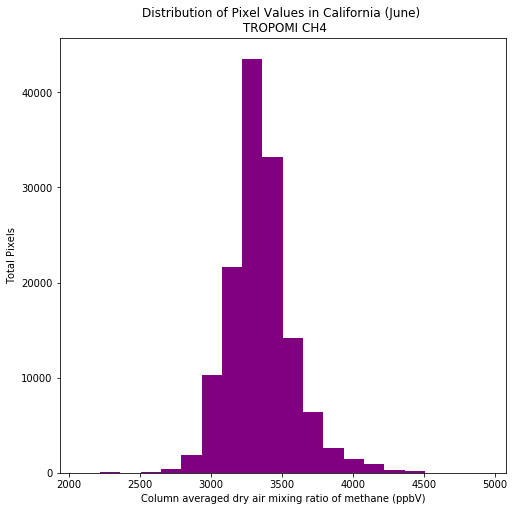

In [4]:
# Explore the data by plotting a histogram with earthpy
ax=ep.hist(ch4_data,
        figsize=(8,8),
        colors="purple",
        xlabel="Column averaged dry air mixing ratio of methane (ppbV)",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values in California (June) \n TROPOMI CH4")

Methane data is overall sparse on a monthly basis. However it is clear that there is not a long tail on either side of the spectrum.

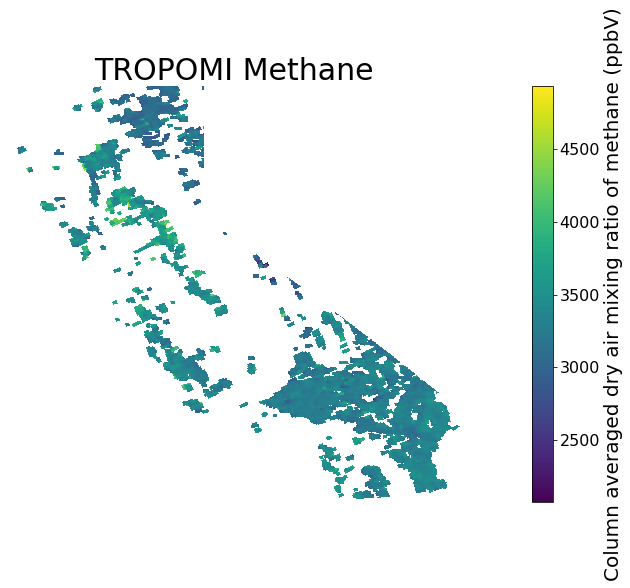

In [5]:
fig, ax = plt.subplots( figsize=(20, 8))
plt_ch4 = ax.imshow(ch4_data)
ax.set_title('TROPOMI Methane', fontsize=30)
cb = fig.colorbar(plt_ch4, ax=ax)
cb.set_label(label='Column averaged dry air mixing ratio of methane (ppbV)', fontsize=20)
cb.ax.tick_params(labelsize=16)
ax.set_aspect('equal')
ax.set_frame_on(False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

Since this is so sparse we did not end up using this as a feature but it is still a good example of why our research question to predict methane across California is vital.

### NO2 data (June)


In [6]:
# Load & plot the data
no2_path = os.path.join("Data","google_earth_engine", "NO2_2019.tif")

with rio.open(no2_path) as no2_src:
    # Masked = True sets no data values to np.nan if they are in the metadata
    no2_data = no2_src.read(6, masked=True)
    no2_meta = no2_src.profile

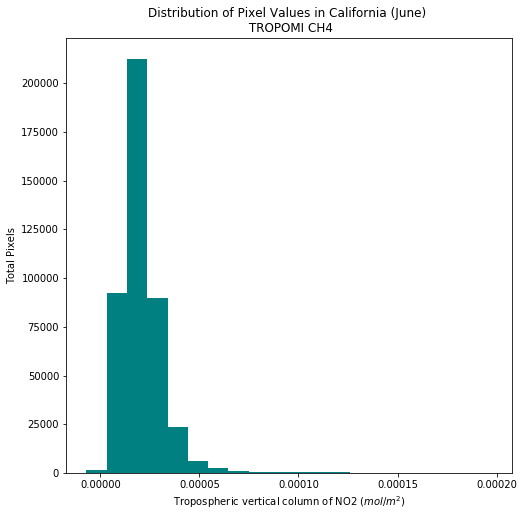

In [7]:
# Explore the data by plotting a histogram with earthpy
ax=ep.hist(no2_data,
        figsize=(8,8),
        colors="teal",
        xlabel="Tropospheric vertical column of NO2 ($mol/m^2$)",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values in California (June) \n TROPOMI CH4")

NO2 cover is substantially better than for methane. There seems to be a tail towards the higher values. We see that these higher values seem to be around the more urban areas as well as in the San Joaquin valley.

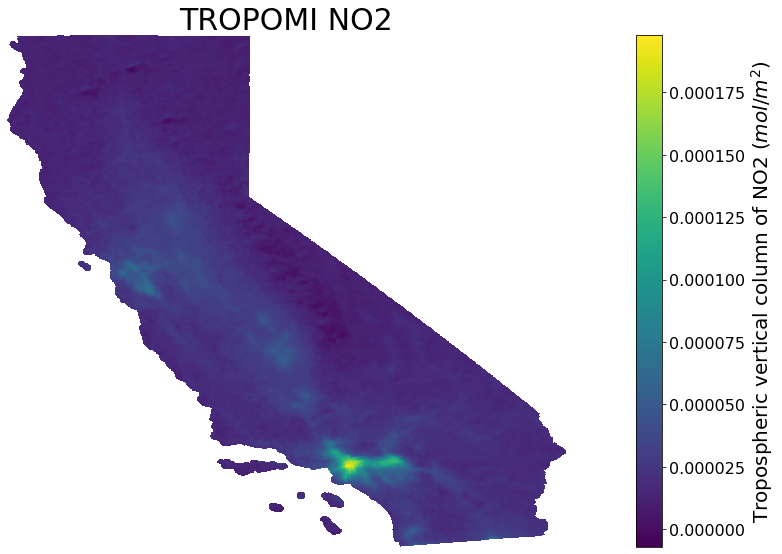

In [8]:
fig, ax = plt.subplots( figsize=(20, 8))
plt_no2 = ax.imshow(no2_data)
ax.set_title('TROPOMI NO2', fontsize=30)
cb = fig.colorbar(plt_no2, ax=ax)
cb.set_label(label='Tropospheric vertical column of NO2 ($mol/m^2$)', fontsize=20)
cb.ax.tick_params(labelsize=16)
ax.set_aspect('equal')
ax.set_frame_on(False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

## EDA: AirNow 

### About the Data
*Retrieval Link*: [Link](https://docs.airnowapi.org)

*Description*: AirNow is run by the US EPA and has a network of sensors across the United States. There are over 2000 sensors and data for parameters such as PM 2.5, PM 10, SO<sub>2</sub>, Ozone, NO<sub>2</sub>, and CO are collected. We've downloaded some hourly data for sensors across California. 


### Brief Description


#### Sensor location

We first downloaded sensor locations for California from the API. The API code can be found in `00_Exploration_AirNow_FULL.py`.

In [9]:
sensor_loc = pd.read_csv('Data/airnow_ca_sensors.csv')
sensor_loc.head()

,Unnamed: 0,index,SiteName,AgencyName,FullAQSCode,IntlAQSCode,geometry
0,0,0,Jacobs,North Coast Unified Air Quality Management Dis...,060231004,840060231004,POINT (-124.177498 40.776943)
1,1,5,Fort Bragg High School,Mendocino County AQMD,060450010,840060450010,POINT (-123.78766 39.43734)
2,2,6,Willits Justice Center,Mendocino County AQMD,060452002,840060452002,POINT (-123.352661 39.411743)
3,3,7,MMCA82038,California Air Resources Board,840MMCA82038,840840MMCA82038,POINT (-123.235896 38.907373)
4,4,8,Ukiah Library,Mendocino County AQMD,060450006,840060450006,POINT (-123.206528 39.150478)


In [10]:
sensor_loc.shape

(216, 7)

In [11]:
sensor_loc['AgencyName'].unique()

array(['North Coast Unified Air Quality Management District',
       'Mendocino County AQMD', 'California Air Resources Board',
       'San Francisco Bay Area AQMD', 'Siskiyou County APCD',
       'Shasta County Air Quality Management District',
       'Tehama County Air Pollution Control District',
       'Monterey Bay Unified APCD', 'Yolo-Solano AQMD',
       'National Park Service', 'Sacramento Metro. AQMD',
       'San Joaquin Valley Unified APCD', 'Placer County APCD',
       'Northern Sierra AQMD', 'San Luis Obispo County APCD',
       'Santa Barbara County Air Pollution Control District',
       'Tachi-Yokut Tribe', 'Ventura County  APCD',
       'Great Basin Unified Air Pollution Control District',
       'Forest Service', 'South Coast AQMD', 'Mojave Desert AQMD',
       'San Diego APCD', 'Twenty-Nine Palms Band of Mission Indians',
       'Imperial County Air Pollution Control District'], dtype=object)

We have 216 sensors across California. They come various agencies, which most likely correlates with their location.

### Example raw data
We extracted data by location, pinging the API for data for each month (this can also be found in`00_Exploration_AirNow_FULL.py`). Here is an example of a compiled csv for all data in one month.

In [12]:
# old file path: 'output/air_now/raw/by_hour/2016-12-01_2016-12-31.csv'
df_2016_12 = pd.read_csv('Data/2016-12-01_2016-12-31.csv',
                        dtype={'FullAQSCode': object,'IntlAQSCode': object})
df_2016_12.head()

,Unnamed: 0,Latitude,Longitude,UTC,Parameter,Unit,Value,RawConcentration,AQI,Category,SiteName,AgencyName,FullAQSCode,IntlAQSCode,date
0,18,40.776943,-124.177498,2016-12-01 00:00:00-08:00,NO2,PPB,6.00,6.17,6,1,Jacobs,North Coast Unified Air Quality Management Dis...,060231004,840060231004,2016-12-01
1,19,40.776943,-124.177498,2016-12-01 00:00:00-08:00,SO2,PPB,0.00,0.40,0,1,Jacobs,North Coast Unified Air Quality Management Dis...,060231004,840060231004,2016-12-01
2,20,40.776943,-124.177498,2016-12-01 00:00:00-08:00,CO,PPM,0.51,0.51,-999,0,Jacobs,North Coast Unified Air Quality Management Dis...,060231004,840060231004,2016-12-01
3,21,40.776943,-124.177498,2016-12-01 01:00:00-08:00,NO2,PPB,5.00,5.82,5,1,Jacobs,North Coast Unified Air Quality Management Dis...,060231004,840060231004,2016-12-01
4,22,40.776943,-124.177498,2016-12-01 01:00:00-08:00,SO2,PPB,0.00,0.37,0,1,Jacobs,North Coast Unified Air Quality Management Dis...,060231004,840060231004,2016-12-01


In [13]:
df_2016_12.describe()

,Unnamed: 0,Latitude,Longitude,Value,RawConcentration,AQI,Category
count,308190.000000,308190.000000,308190.000000,308190.000000,308190.000000,308190.000000,308190.000000
mean,1117.155745,36.259646,-119.874428,14.116841,-1.559637,-90.654424,0.993459
std,862.184306,2.056648,1.982119,16.828233,127.965605,322.013830,0.491424
min,0.000000,32.735500,-124.177498,-2.200000,-999.000000,-999.000000,0.000000
25%,429.000000,34.143900,-121.623271,3.900000,2.000000,5.000000,1.000000
50%,909.000000,36.458100,-120.075060,11.000000,9.400000,15.000000,1.000000
75%,1642.000000,37.950750,-118.068484,21.000000,22.000000,28.000000,1.000000
max,4410.000000,40.776943,-114.602090,978.200000,3922.100000,874.000000,6.000000


So this decribe is a little pointless so its for a couple different params. Let's just do this for Ozone.

In [14]:
df_2016_12.loc[df_2016_12['Parameter']=='OZONE'].describe()

,Unnamed: 0,Latitude,Longitude,Value,RawConcentration,AQI,Category
count,99581.000000,99581.000000,99581.000000,99581.000000,99581.000000,99581.000000,99581.000000
mean,969.439903,36.159679,-119.793945,18.761320,-13.362318,16.928691,0.999548
std,781.322152,2.055507,1.968752,11.695339,180.098644,24.152351,0.021253
min,0.000000,32.789561,-123.202995,-1.000000,-999.000000,-999.000000,0.000000
25%,367.000000,34.243132,-121.574684,9.000000,6.000000,8.000000,1.000000
50%,732.000000,36.209286,-120.040130,18.000000,18.600000,17.000000,1.000000
75%,1386.000000,37.938300,-118.127142,28.000000,30.000000,26.000000,1.000000
max,4406.000000,40.689400,-114.602090,49.000000,137.300000,45.000000,1.000000


We can see that we have some invalid cocentration measurements (-999 as null value). 

### Monthly average data


After compiling hourly data for 2016 through 2017, we took average measurements for each month for each sensor location (see `01_Monthly_Average_AIRNOW.py` to see details). Here is some brief EDA we did to understand our data.

In [15]:
# original path: 'output/air_now/airnow_monthly_averages.json/airnow_monthly_averages.shp'
airnow_monthly = gpd.read_file('Data/airnow_monthly_averages/airnow_monthly_averages.shp')
airnow_monthly.head()

,Latitude,Longitude,Parameter,Unit,Category,SiteName,AgencyName,FullAQSCod,IntlAQSCod,year,month,Value_mean,Value_coun,RawConcent,RawConce_1,AQI_mean,AQI_count,geometry
0,32.7355,-116.3454,PM10,UG/M3,0,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,1,-0.150000,2,0.000000,2,NaN,0,POINT (-116.34540 32.73550)
1,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,1,2.933515,734,2.922131,732,2.750681,734,POINT (-116.34540 32.73550)
2,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,2,5.725291,3440,5.867347,3430,5.306686,3440,POINT (-116.34540 32.73550)
3,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,3,7.577446,2944,7.586957,2944,7.009511,2944,POINT (-116.34540 32.73550)
4,32.7355,-116.3454,PM10,UG/M3,1,Manzanita Tribe 1,Manzanita Band of the Kumeyaay Nation,60732000,840060732000,2016,4,11.366199,2139,11.404494,2136,10.531557,2139,POINT (-116.34540 32.73550)


In [16]:
airnow_monthly.columns

Index(['Latitude', 'Longitude', 'Parameter', 'Unit', 'Category', 'SiteName',
       'AgencyName', 'FullAQSCod', 'IntlAQSCod', 'year', 'month', 'Value_mean',
       'Value_coun', 'RawConcent', 'RawConce_1', 'AQI_mean', 'AQI_count',
       'geometry'],
      dtype='object')

#### Sensor types
We wanted to see how much of the network was made up of sensors designated for detecting different parameters.

Ozone sensors are most prevalent, with the next being PM 2.5 sensors.

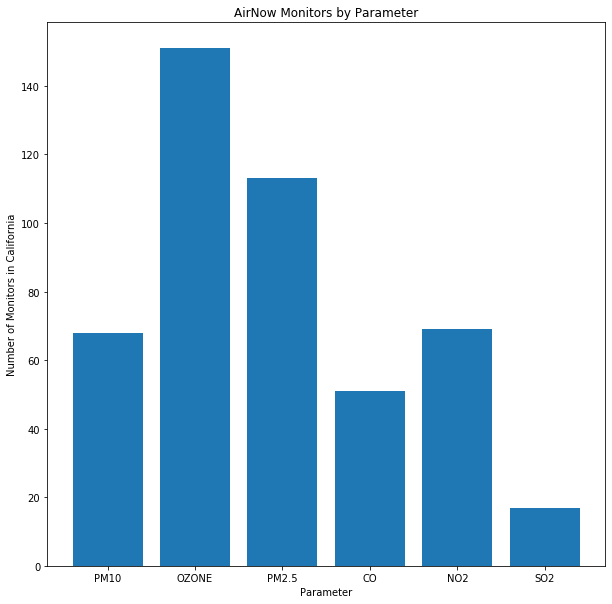

In [17]:
# Create labels for pie chart
labels = airnow_monthly['Parameter'].unique()
# Find the number of unique locations there are that measure this parameter
sizes = [len(airnow_monthly.loc[airnow_monthly['Parameter']==i,'SiteName'].unique()) for i in airnow_monthly['Parameter'].unique()]

# Create bar chart
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(labels,height=sizes)
ax.set_xlabel('Parameter')
ax.set_ylabel('Number of Monitors in California')
ax.set_title('AirNow Monitors by Parameter')
plt.show()

### Sensor locations

Our sensors seem to be clustered in more urban areas and are sparser in rural regions (where methane data is needed).

Text(0.5, 1, 'AirNow monitors across California')

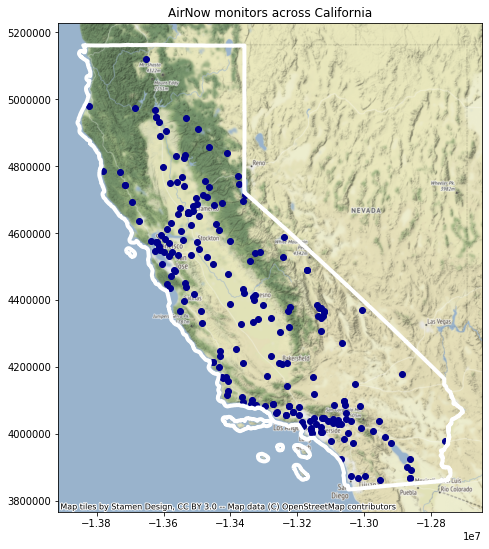

In [18]:
# Bring in California outline
ca_gpd = gpd.read_file('zip://Data/ca-state-boundary.zip')

# Add all Air Now monitors on plot
airnow_monthly_locs = airnow_monthly[['SiteName','geometry']].drop_duplicates()

ax = airnow_monthly_locs.to_crs('EPSG:3857').plot(figsize=(9, 9), color='darkblue')
ca_gpd.to_crs('EPSG:3857').plot(facecolor='none', edgecolor='white',linewidth=4, ax=ax)
# Add a base map
cx.add_basemap(ax)
ax.set_title('AirNow monitors across California')

### Parameter statistics

It seems that NO2 concentrations increase in 2017, while Ozone concentrations remain about the same. 

In [19]:
airnow_monthly.groupby(['year','Parameter', 'Unit']).agg({'Value_mean': ['mean']})

Value_mean
                           mean
year Parameter Unit            
2016 CO        PPM     0.364495
     NO2       PPB    13.244315
     OZONE     PPB    47.063055
     PM10      UG/M3  76.284838
     PM2.5     UG/M3  11.925440
     SO2       PPB     5.817451
2017 CO        PPM     0.357774
     NO2       PPB    18.366278
     OZONE     PPB    48.073824
     PM10      UG/M3  85.188276
     PM2.5     UG/M3  17.827011
     SO2       PPB     3.997960

## Exploratory Data Analysis: Land Use/Land Cover

### About the Data
Our land cover data came from the USGS National Land Cover Database (NLCD), which provides nationwide data on land cover and land cover change at a 30m resolution with a 16-class legend based on a modified Anderson Level II classification system. 

Source link: https://www.mrlc.gov/data?f%5B0%5D=category%3Aland%20cover&f%5B1%5D=year%3A2016

#### The land cover class descriptions are as follows:

11: **Open Water**- areas of open water, generally with less than 25% cover of vegetation or soil.

12: **Perennial Ice/Snow**- areas characterized by a perennial cover of ice and/or snow, generally greater than 25% of total cover.

21: **Developed, Open Space**- areas with a mixture of some constructed materials, but mostly vegetation in the form of lawn grasses. Impervious surfaces account for less than 20% of total cover. These areas most commonly include large-lot single-family housing units, parks, golf courses, and vegetation planted in developed settings for recreation, erosion control, or aesthetic purposes.

22: **Developed, Low Intensity**- areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 20% to 49% percent of total cover. These areas most commonly include single-family housing units.

23: **Developed, Medium Intensity**- areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 50% to 79% of the total cover. These areas most commonly include single-family housing units.

24: **Developed High Intensity**- highly developed areas where people reside or work in high numbers. Examples include apartment complexes, row houses and commercial/industrial. Impervious surfaces account for 80% to 100% of the total cover.

31: **Barren Land (Rock/Sand/Clay)** - areas of bedrock, desert pavement, scarps, talus, slides, volcanic material, glacial debris, sand dunes, strip mines, gravel pits and other accumulations of earthen material. Generally, vegetation accounts for less than 15% of total cover.

41: **Deciduous Forest**- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species shed foliage simultaneously in response to seasonal change.

42: **Evergreen Forest**- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species maintain their leaves all year. Canopy is never without green foliage.

43: **Mixed Forest**- areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. Neither deciduous nor evergreen species are greater than 75% of total tree cover.

52: **Shrub/Scrub**- areas dominated by shrubs; less than 5 meters tall with shrub canopy typically greater than 20% of total vegetation. This class includes true shrubs, young trees in an early successional stage or trees stunted from environmental conditions.

71: **Grassland/Herbaceous**- areas dominated by gramanoid or herbaceous vegetation, generally greater than 80% of total vegetation. These areas are not subject to intensive management such as tilling, but can be utilized for grazing.

81: **Pasture/Hay**-areas of grasses, legumes, or grass-legume mixtures planted for livestock grazing or the production of seed or hay crops, typically on a perennial cycle. Pasture/hay vegetation accounts for greater than 20% of total vegetation.

82: **Cultivated Crops** -areas used for the production of annual crops, such as corn, soybeans, vegetables, tobacco, and cotton, and also perennial woody crops such as orchards and vineyards. Crop vegetation accounts for greater than 20% of total vegetation. This class also includes all land being actively tilled.

90: **Woody Wetlands**- areas where forest or shrubland vegetation accounts for greater than 20% of vegetative cover and the soil or substrate is periodically saturated with or covered with water.

95: **Emergent Herbaceous Wetlands**- Areas where perennial herbaceous vegetation accounts for greater than 80% of vegetative cover and the soil or substrate is periodically saturated with or covered with water.

In [ ]:
#Load data
lulc_data = gpd.read_file('Data/CH4_Emitters_All_LU_EmitterType.geojson')

After the data cleaning steps outline in the previous section (which can also be found in the notebook `01_Clean_Land_Cover_USGS`), we now have a dataframe that contains two categories of land cover features: <br>
1. The percent of each land cover class found in each emitter buffer
2. A set of dummy variables for which land cover class was the majority class for that emitter buffer. 


We're interested in looking at which land cover classes were the most common majority class across the emitter buffers. 

In [ ]:
#Plot majority class
fig, ax = plt.subplots(figsize = (15,7))
sns.histplot(data = lulc_data, x = 'majority_class', edgecolor = 'white', color = 'coral') 
plt.title('Distribution of the Majority Land Cover Class in each Emitter Buffer', fontweight='bold', size = 15)
ax.set_ylabel('Count', size = 15)
ax.set_xlabel('Land Use Class', size = 15)
plt.xticks(rotation = 30, ha = 'right')

Our plot shows that `Grassland` is the most common majority land class type, followed by `Cultivated Crops`, `Developed: Medium Intensity`, and `Shrub Scrub`. We can also plot the log of the count of each majority class so that we can see more of the distribution from the other categories. 

In [ ]:
#Plot majority class (log scale)
fig, ax = plt.subplots(figsize = (15,7))
sns.histplot(data = lulc_data, x = 'majority_class', edgecolor = 'white', color = 'coral') 
plt.title('Distribution of the Majority Land Cover Class in each Emitter Buffer', fontweight='bold', size = 15)
ax.set_ylabel('Log Count', size = 15)
ax.set_xlabel('Land Use Class', size = 15)
ax.set_yscale('log')
plt.xticks(rotation = 30, ha = 'right')

We can also look at some descriptive statistics of our Land Cover Percent columns. 

In [ ]:
#Plot descriptive statistics for each land cover
columns = lulc_data.columns[16:32]

for column in columns:
    print(lulc_data[column].describe())

`Grassland` makes up an average of 40% of the pixel classes across emitter buffers, followed by `Cultivated Crops` at 21%. Other significant classes include `Dev: Open Space` at an average of 8.5%, `Dev: Medium Intensity` at 8.2%, `Shrub Scrub` at 7.9%. 

In [ ]:
# Remove: 
del lulc_data

## EDA: Emitter Type 

### About the Data

The VISTA-CA dataset from Oak Ridge National Lab Distributed Active Archived Center has the locations of known and expected sources of methane emissions from California. These locations were sourced from several local, state, and federal datasets. 

Citation: Hopkins, F.M., T. Rafiq, and R.M. Duren. 2019. Sources of Methane Emissions (Vista-CA), State of California, USA. ORNL DAAC, Oak Ridge, Tennessee, USA.

Following the one-hot encoding step outlined in the previous section (which can also be found in the notebook `01_Clean_Land_Cover_USGS`), for this feature we have a set of dummy variables for each emitter type found in the VISTA-CA dataset. 

We're interested in looking at the distribution of emitter types across the dataset. 

In [ ]:
#Plot distribution of emitter types
fig, ax = plt.subplots(figsize = (15,7))
sns.histplot(data = data, y = 'Vista_SType', edgecolor = 'white',  color = 'darkcyan')
plt.title('Distribution of Emitter Types, VISTA-CA Dataset', fontweight='bold', size = 15)
ax.set_ylabel('')

`Oil and Gas wells` clearly dominate the dataset as the most common emitter type. With this category included, we can barely see the count of the other emitter types. We'll try removing this category to take a closer look at the distribution of the other types of emitters. 

In [ ]:
#Remove oil and gas well so we can take a closer look at the distribution of the other types of emitters
data_nowells = data[data['Vista_SType'] != 'Oil and Gas Well']

In [ ]:
#Plot without oil and gas wells
fig, ax = plt.subplots(figsize = (15,7))
sns.histplot(data = data_nowells, y = 'Vista_SType', edgecolor = 'white',  color = 'mediumaquamarine')
plt.title('Distribution of Emitter Types, Oil and Gas Wells Removed', fontweight='bold', size = 15)
ax.set_ylabel('')

From this graph, we can see that the second most common emitter type is `Oil and Gas Facility Boundary`, followed by `Dairy`, `Natural Gas Station`, and `Landfill`. 

## EDA: Nearest Neighboring Emitters 

In [ ]:
# set data directory and out directory
datadir = os.sep.join(['/Volumes', 'Brain', 'GIS', 'ER131', 'Project', 'Data'])
outdir = os.sep.join(['/Volumes', 'Brain', 'GIS', 'ER131', 'Project', 'Output'])

In [ ]:
vistadir = os.sep.join([outdir, 'VISTA_NNEmitter'])a
vista_nn = gpd.read_file(os.sep.join([vistadir, 'VISTA_NNEmitter.geojson']))

In [ ]:
print(vista_nn.shape)
vista_nn.describe()

In [ ]:
plt.hist(vista_nn.NN_Distance_m, bins = 12, color = 'aquamarine', edgecolor = 'grey')
plt.title('Frequency distribution of distance between nearest neighboring emitters')
plt.xlabel('Distance between nearest neighbors')
plt.ylabel('Log of number of emitters')
plt.yscale('log')

The median distance between neighboring emitter facilities is 27 meters. The overall distribution is highly positively skewed, with 75 percent of facilities within 77 m of its nearest neighbor. We assume this is primarily driven by oil and gas wells, which are densely distributed.

## EDA: Natural Gas Intrastate Pipelines 


### About the Data 
Shapefiles of intrastate natural gas pipelines in the US from the US Energy Information Administration, updated April 28, 2020.  


Link: https://www.eia.gov/maps/layer_info-m.php

In [ ]:
ng_pipelines = gpd.read_file('Data/ng_pipelines/NaturalGas_Pipelines_US_202001.shp')
ng_pipelines.head()

In [ ]:
ng_pipelines.plot(color='red',figsize=(12, 6))

We constructed buffers of different sizes around each data point, and calculated the length of natural gas pipeline within each buffer radius. 

## EDA: County-level cow density 

### About the Data
The data below come from the [USDA National Agricultural Statistics Service QuickStats], from the most recent California livestock census (2017), by California county. Includes: 

    1. Total count of cattle including calves
    2. Total count of milk cows (a subset of (a))
    3. Total count of milk-producing operations that had sales in the census year
    
Link: https://quickstats.nass.usda.gov/#D0FD8ACF-923C-3308-91BB-1E1ACE7662B9 

In [ ]:
# Read in counties 
counties = gpd.read_file(os.sep.join(['Data', 'CA_Counties', 'CA_Counties_TIGER2016.shp']))

# Read in cows 
cows = pd.read_csv('Data/cows_ch4.csv')
cows['NAME'] = cows['County'].str.title()
# Merge with counties
cow_counties = counties.merge(cows, how='left')


In [ ]:
print(counties.shape)
print(cows.shape)

In [ ]:
# counties.head()
# cows.head()
cow_counties.head()

In [ ]:
# Plot cow counts by county 
cow_counties.plot(column='Value', legend=True,figsize=(8,8))
plt.title('Number of Cows Per County', fontsize = 20)
plt.tight_layout()
plt.show()

### Processing 
I calculated the area-weighted estimate of cow density by county (cows/km^2), and from the intersection of the Vista 'points' (which are actually polygons) and California counties, county-level cow densities were estimated by area-weighting the intersection of Vista polygons that lie within multiple counties. 

# Merged Data Statistics  

Stats were calculated on the original 234,576 Vista points, and then subset to the 48,332 of these for which we were able to obtain Aviris flight path methane observations. Several of the Land Use features become constants across this subset, and so are removed from the data. 


In [ ]:
df = gpd.read_file("Data/target_and_features_AQ3.geojson")

In [ ]:
df = df.drop(['Vista_ID','AVIRIS_CH4_median_ppmm', 'AVIRIS_CH4_pxcount','NearestNeighbor','NN_Type'], axis = 1)
df = df.drop(['LULC_ice_snow_perc','LULC_total_perc','LULC_Barren.Land',
              'LULC_Dev..Open.Space','LULC_Evergreen.Forest',
              'LULC_Herbaceous.Wetlands','LULC_Pasture.Hay'], axis = 1)
df = df.drop_duplicates()

In [ ]:
df.describe()

## Final VISTA Observation Locations 

In [ ]:
# Add all 
ax = df.to_crs('EPSG:3857').plot(figsize=(9, 9), color='darkblue')
ca_gpd.to_crs('EPSG:3857').plot(facecolor='none', edgecolor='white',linewidth=4, ax=ax)
# Add a base map
cx.add_basemap(ax)
ax.set_title('Final VISTA Sites')

### Target variable 
The target variable based on Aviris flight paths has a mean of 1.11 e 10<sup>-4</sup> kg CH<sub>4</sub>, and a standard deviation of 4.5 e 10<sup>-5</sup> kg CH<sub>4</sub>.  


In [ ]:
df[['CH4_Mass_kg']].describe()

In [ ]:
# Histogram
plt.figure(figsize=(12,8)) 
plt.hist(df['CH4_Mass_kg'],
         bins = np.logspace(np.log10(0.00001),np.log10(0.01), 50),
         color = "cornflowerblue")
plt.xlabel('AVIRIS Flight Path Methane (kg)')
plt.ylabel('# Observations')
plt.title("Histogram of AVIRIS Flight Path Methane",fontsize = 20)
plt.gca().set_xscale("log")


### AVIRIS Methane Observations by Emitter Type

The majority (~97%) of AVIRIS observations are associated with the Oil and Gas Well emitter type. The highest values are included in this category. Seven emitter types (Digesters, Feed Lots, Liquified Natural Gas Fueling Stations, Natural Gas Processing Plants, Natural Gas Storage Field, Refineries, and Wastewater Treatment Plants) contained only 10 or fewer observations. 

In [ ]:
emitter_types = ['EmitterType_Composting.Sites','EmitterType_Compressed.Natural.Gas.Fueling.Station',
                 'EmitterType_Dairy', 'EmitterType_Digester', 'EmitterType_Feed.Lot', 'EmitterType_Landfill',
                 'EmitterType_Liquefied.Natural.Gas.Fueling.Station', 'EmitterType_Natural.Gas.Processing.Plants',
                 'EmitterType_Natural.Gas.Station', 'EmitterType_Natural.Gas.Storage.Field', 
                 'EmitterType_Oil.and.Gas.Facility.Boundary','EmitterType_Oil.and.Gas.Field.Boundary',
                 'EmitterType_Oil.and.Gas.Well', 'EmitterType_Power.Plant',
                 'EmitterType_Refinery', 'EmitterType_Wastewater.Treatment.Plant']

emitter_cats = df[['CH4_Mass_kg']].loc[df[emitter_types[0]] == 1] 
emitter_cats['EmitterType'] = emitter_types[0]

for et in emitter_types[1:len(emitter_types)]:
    df_sub = df[['CH4_Mass_kg']].loc[df[et] == 1] 
    df_sub['EmitterType'] = et
    emitter_cats = pd.concat([emitter_cats,df_sub])

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(data=emitter_cats, orient="h", 
                 y="EmitterType", x="CH4_Mass_kg",
                 palette="Set2").set(title="AVIRIS Methane by Emitter Type")

In [ ]:
# Bar Plot of Observation Counts
emitter_cat_counts = emitter_cats['EmitterType'].value_counts().to_frame()
emitter_cat_counts = emitter_cat_counts.rename(columns = {"EmitterType":"Count"})
emitter_cat_counts = emitter_cat_counts.rename_axis("EmitterType").reset_index()

ax = sns.barplot(data = emitter_cat_counts,x="Count", y="EmitterType", ci="sd", 
                 order=emitter_types).set(title = "Observation Counts by Emitter Type")

#### Table of Observation Counts by Emitter Type 

Composting Sites and Dairies have the highest mean Aviris CH<sub>4</sub> values, but not significantly so. 

In [ ]:
emitter_stats = emitter_cats.groupby('EmitterType')['CH4_Mass_kg'].describe()
emitter_stats

## Correlation between variables 

The correlation matrix of our `CH4_Mass_kg` feature and different features is shown below, excluding the binary land use and emitter type variables. 

`CH4_Mass_kg` isn't particularly correlated with any feature. Related or conflicting land use classes are positively and negatively correlated respectively (e.g. developed land classes and herbaceous/pasture land classes are negatively correlated with each other). 

As expected, buffered pipelengths are highly correlated with each other, and with various developed land use categories. TROPOMI NO<sub>2</sub> is also positively correlated with developed land use categories. TROPOMI O<sub>3</sub> has the strongest monthly trend. 

In [ ]:
# Correlation Matrix 
cM = df.drop(['LULC_majority_class', 'LULC_Cultivated.Crops', 'LULC_Dev..Low.Int',
                'LULC_Dev..Med.Int', 'LULC_Grassland', 'LULC_Mixed.Forest',
                'LULC_Open.Water', 'LULC_Shrub.Scrub','EmitterType_Composting.Sites',
                'EmitterType_Compressed.Natural.Gas.Fueling.Station',
                'EmitterType_Dairy', 'EmitterType_Digester', 'EmitterType_Feed.Lot',
                'EmitterType_Landfill',
                'EmitterType_Liquefied.Natural.Gas.Fueling.Station',
                'EmitterType_Natural.Gas.Processing.Plants',
                'EmitterType_Natural.Gas.Station',
                'EmitterType_Natural.Gas.Storage.Field',
                'EmitterType_Oil.and.Gas.Facility.Boundary',
                'EmitterType_Oil.and.Gas.Field.Boundary',
                'EmitterType_Oil.and.Gas.Well', 'EmitterType_Power.Plant',
                'EmitterType_Refinery', 'EmitterType_Wastewater.Treatment.Plant'], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cM, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cM, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(title="Target and Feature Correlation Matrix")


## Correlation between air quality variables

In [ ]:
# AQ Pair Plots
sns.pairplot(df[['CH4_Mass_kg','aviris_month',
                 'tropomi_no2_mean', 'tropomi_o3_mean',
                 'tropomi_so2_mean', 'PM10', 'OZONE', 'PM2.5', 'NO2']])

## Correlation between pipeline lengths and developed land use classes 

In [ ]:
sns.pairplot(df[['CH4_Mass_kg','ng_pipelength_2', 'ng_pipelength_1000',
             'ng_pipelength_5000', 'ng_pipelength_10000',
             'ng_pipelength_50000','LULC_developed_open_space_perc', 
             'LULC_developed_low_int_perc','LULC_developed_med_int_perc', 
             'LULC_developed_high_int_perc','tropomi_no2_mean']])
